<a href="https://colab.research.google.com/github/IEwaspbusters/KopuruVespaCompetitionIE/blob/main/Competition_subs/2021-04-28_submit/batch_LARVAE/HEX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost Years: Prediction with Mario's Cluster Variable and selected Weather Variables (according to Feature importance), including GridSearchCV (without Population, since it is reflected in Cluster).

## Import the Data & Modules

In [1]:
# Base packages -----------------------------------
import pandas as pd
import numpy as np
import shap
import warnings

# Data Viz -----------------------------------
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10) # to set figure size when ploting feature_importance

# XGBoost -------------------------------
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance, plot_tree # built-in function to plot features ordered by their importance & tree

# SKLearn -----------------------------------------
from sklearn import preprocessing # scaling data
from sklearn.model_selection import GridSearchCV

In [2]:
# Function that checks if final Output is ready for submission or needs revision   

def check_data(HEX):
    
    def template_checker(HEX):
        submission_df = (HEX["CODIGO MUNICIPIO"].astype("string")+HEX["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        template_df = (template["CODIGO MUNICIPIO"].astype("string")+template["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        check_df = pd.DataFrame({"submission_df":submission_df,"template_df":template_df})
        check_df["check"] = check_df.submission_df == check_df.template_df
        if (check_df.check == False).any():
            pd.options.display.max_rows = 112
            return check_df.loc[check_df.check == False,:]
        else:  
            return "All Municipality Names and Codes to be submitted match the Template"
    
    print("Submission form Shape is", HEX.shape)
    print("Number of Municipalities is", HEX["CODIGO MUNICIPIO"].nunique())
    print("The Total 2020 Nests' Prediction is", int(HEX["NIDOS 2020"].sum()))

    assert HEX.shape == (112, 3), "Error: Shape is incorrect."
    assert HEX["CODIGO MUNICIPIO"].nunique() == 112, "Error: Number of unique municipalities is correct."    
    return template_checker(HEX)

In [3]:
# Importing datasets from GitHub as Pandas Dataframes
queen_train = pd.read_csv("../Feeder_years/WBds03_QUEENtrainYears.csv", encoding="utf-8") #2018+2019 test df
queen_predict = pd.read_csv("../Feeder_years/WBds03_QUEENpredictYears.csv", encoding="utf-8") #2020 prediction df
queen_clusters = pd.read_csv("../auxiliary_files/WBds_CLUSTERSnests.csv",sep=",")
template = pd.read_csv("../../../Input_open_data/ds01_PLANTILLA-RETO-AVISPAS-KOPURU.csv",sep=";", encoding="utf-8")

## Further Clean the Data

### Filter according to assumptions (Clusters & Relevant Municipalities)

In [4]:
# Adding cluster labels

queen_train = pd.merge(queen_train, queen_clusters, how = 'left', left_on = 'municip_code', right_on = 'municip_code')
queen_predict = pd.merge(queen_predict, queen_clusters, how = 'left', left_on = 'municip_code', right_on = 'municip_code')

In [5]:
# Remove the Municipalities to which we did not assign a Cluster, since there was not reliable data for us to predict -> Bilbao

queen_train = queen_train.loc[queen_train.municip_code != 48020,:].copy()
queen_predict = queen_predict.loc[queen_predict.municip_code != 48020,:].copy()

### Arrange data into a features matrix and target vector

In [6]:
# selecting the train X & y variables

# Y will be the response variable (filter for the number of wasp nests - waspbust_id)  
y_train = queen_train.NESTS

# X will be the explanatory variables. Remove response variable and non desired categorical columns such as (municip code, year, etc...)
X_train = queen_train.iloc[:,4:-10].drop(["station_code"],axis=1).copy()
X_train["cluster"] = queen_train.Cluster.copy()

# We want to predict our response variable (number of nests in 2020). Remove response variable and non desired categorical columns such as (municip code, year, etc...)
X_test = queen_predict.iloc[:,4:-10].drop("station_code",axis=1).copy()
X_test["cluster"] = queen_predict.Cluster.copy()

Check if the shape of the features and their labels match or if there are errors raised

In [7]:
# Perform checks of features labels & their shapes

assert X_test.shape[1] == X_train.shape[1], "Error: Number of columns do not match!"
assert (X_test.columns == X_train.columns).any(), "Error: Columns labels do not match"
assert y_train.shape == (222,), "Error: y shape is incorrect!"

## Model Step 1: Finding out the Relevant Variables 

### Scale the Data for better Regressions

In [8]:
# Scale the datasets using MinMaxScaler

X_train_scaled = preprocessing.minmax_scale(X_train) # this creates a numpy array
X_train_scaled = pd.DataFrame(X_train_scaled,index=X_train.index,columns=X_train.columns) # create a Pandas Dataframe == X

#### Choose a class of model by importing the appropriate estimator class

In [9]:
# selecting the XGBoost model and fitting with the train data
model = XGBRegressor(random_state=0, objective="reg:squarederror")

### Use GridSearchCV to find out the best hyperparameters for our XGBoost model with our Fitted Data

In [10]:
# Use GridSearchCV that will automatically split the data and give us the best estimator by:

#1) Establishing hyperparameters to change 
param_grid = {
              "learning_rate": [0.01], 
              "max_depth": [3],
              "gamma" : [0],
              "max_delta_step" : [3],
              "min_child_weight": [6],
              "subsample": [0.8],
              "colsample_bytree": [0.2],
              "reg_lambda" : [1],
              "reg_alpha" : [1],
              "n_estimators": [5000],
              "scale_pos_weight" : [3]
              }

warnings.filterwarnings(action='ignore', category=UserWarning)
grid = GridSearchCV(model, param_grid, cv=3)

#2) Fitting the model with our desired data and check for best results
grid.fit(X_train_scaled, y_train)

#) Retrieve the summary of GridSearchCV for analysis
print(F"The number homogeneous splits conducted by GridSearchCV are: {grid.n_splits_}.")
print(F"The best hyperparameters found were: {grid.best_params_}.")
print(F"The best score found was: {grid.best_score_}.")

The number homogeneous splits conducted by GridSearchCV are: 3.
The best hyperparameters found were: {'colsample_bytree': 0.2, 'gamma': 0, 'learning_rate': 0.01, 'max_delta_step': 3, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 5000, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 3, 'subsample': 0.8}.
The best score found was: 0.018508773181993288.


In [11]:
# Reset warnigns to default (this is used to suppred a warning message from XGBoost model and avoid converting X_train to numpy to keep features name)

warnings.filterwarnings(action='default', category=UserWarning)

#### Fit the model to your data by calling the `.fit()` method of the model instance using the best Hyperparameters

In [12]:
# selecting the XGBoost model according to the best hyperparameters found in GridSearchCV and fitting with the train data

model = grid.best_estimator_
model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=3, max_depth=3,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=5000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=3, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### Selecting the Relevant Variables and filtering according to the results

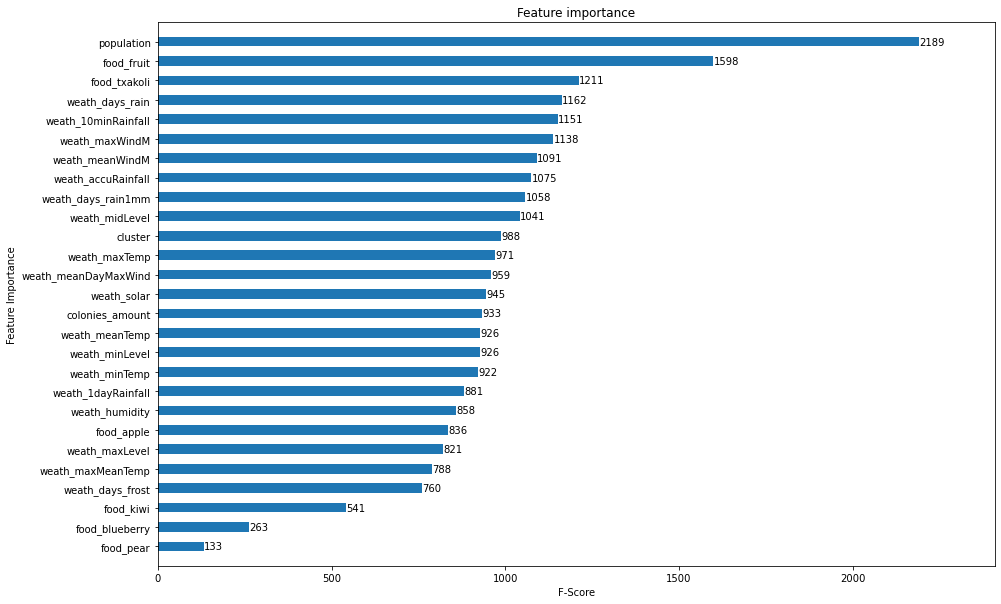

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


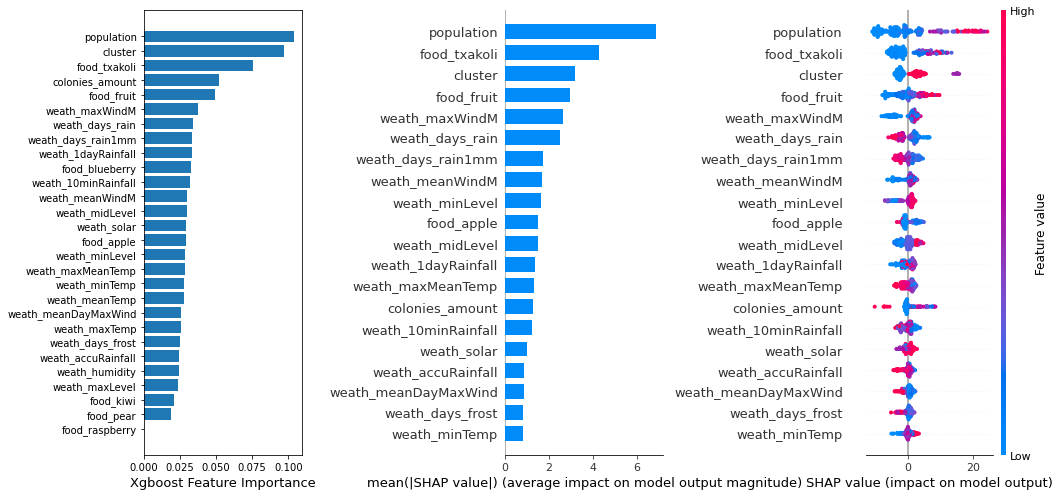

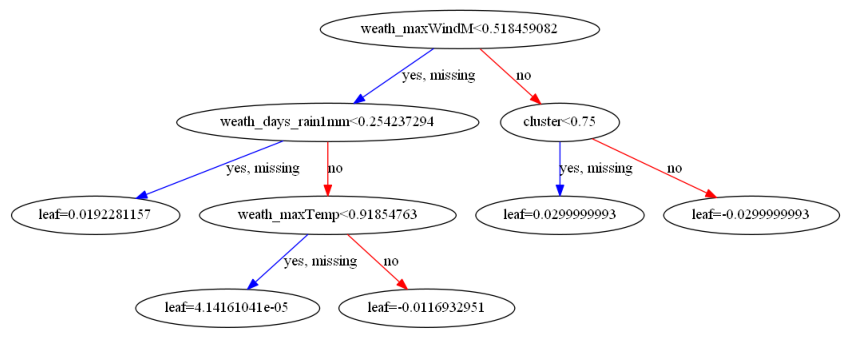

In [13]:
# Plot the Relevant Variables in order to filter the relevant ones per Cluster

# In built plot method from XGBoost
xgb.plot_importance(model,height=0.5,xlabel="F-Score",ylabel="Feature Importance",grid=False)
plt.show()

plt.figure(figsize=(15,7))

# Feature importance from model.feature_importances built-in attribute
sorted_idx = model.feature_importances_.argsort()

plt.subplot(1,3,1)
plt.barh(X_train_scaled.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance", fontsize=13)

# Shap library Summaries
# Shap values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_scaled)

plt.subplot(1,3,2)
shap.summary_plot(shap_values, X_train_scaled, plot_type="bar", plot_size=None, show=False)

plt.subplot(1,3,3)
shap.summary_plot(shap_values, X_train_scaled, plot_size=None, show=False)

plt.subplots_adjust(wspace=10.0)
plt.tight_layout()
plt.show()

#fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(model, num_trees=-1)
plt.show()

In [14]:
# selecting the XGBoost model and fitting with the train data without the irrelevant variables

X_train = queen_train.loc[:,["colonies_amount","food_fruit","weath_days_rain","food_txakoli","Cluster"]].copy()

X_test = queen_predict.loc[:,["colonies_amount","food_fruit","weath_days_rain","food_txakoli","Cluster"]].copy()

## Model Step 2: Prediction of 2020 Nests

**Note: Variables are no longer scaled**

### Scale the Data for better Regressions

In [17]:
# Scale the datasets using MinMaxScaler

# Train set
X_train_scaled = preprocessing.minmax_scale(X_train) # this creates a numpy array
X_train = pd.DataFrame(X_train_scaled,index=X_train.index,columns=X_train.columns) # create a Pandas Dataframe == X

# Test set
X_test_scaled = preprocessing.minmax_scale(X_test) # this creates a numpy array
X_test = pd.DataFrame(X_test_scaled,index=X_test.index,columns=X_test.columns) # create a Pandas Dataframe == X

### Choose a class of model by importing the appropriate estimator class

In [18]:
# selecting the XGBoost model and fitting with the train data

model = XGBRegressor(random_state=0, objective="reg:squarederror")

### Use GridSearchCV to find out the best hyperparameters for our XGBoost model with our Fitted Data

In [19]:
# Use GridSearchCV that will automatically split the data and give us the best estimator by:

#1) Establishing hyperparameters to change 
param_grid = {
              "learning_rate": [0.2], 
              "n_estimators": [1000],
              "max_depth": [6],
              "gamma" : [0.5],
              "scale_pos_weight" : [1.5],
              "max_delta_step" : [1],
              "min_child_weight": [7],
              "subsample": [0.7],
              "colsample_bytree": [0.7],
              "reg_alpha" : [1],
              "reg_lambda" : [2]              
              }

warnings.filterwarnings(action='ignore', category=UserWarning)
grid = GridSearchCV(model, param_grid, cv=3)

#2) Fitting the model with our desired data and check for best results
grid.fit(X_train, y_train)

#) Retrieve the summary of GridSearchCV for analysis
print(F"The number homogeneous splits conducted by GridSearchCV are: {grid.n_splits_}.")
print(F"The best hyperparameters found were: {grid.best_params_}.")
print(F"The best score found was: {grid.best_score_}.")

The number homogeneous splits conducted by GridSearchCV are: 3.
The best hyperparameters found were: {'colsample_bytree': 0.7, 'gamma': 0.5, 'learning_rate': 0.2, 'max_delta_step': 1, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 1000, 'reg_alpha': 1, 'reg_lambda': 2, 'scale_pos_weight': 1.5, 'subsample': 0.7}.
The best score found was: 0.05466829909976145.


In [20]:
# Reset warnigns to default (this is used to suppred a warning message from XGBoost model and avoid converting X_train to numpy to keep features name)

warnings.filterwarnings(action='default', category=UserWarning)

### Fit the model to your data by calling the `.fit()` method of the model instance

In [21]:
# selecting the XGBoost model according to the best hyperparameters found in GridSearchCV and re-fitting with the train data with the appropriate variables

model = grid.best_estimator_
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=1, max_depth=6,
             min_child_weight=7, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=1, reg_lambda=2, scale_pos_weight=1.5, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Tree visualization

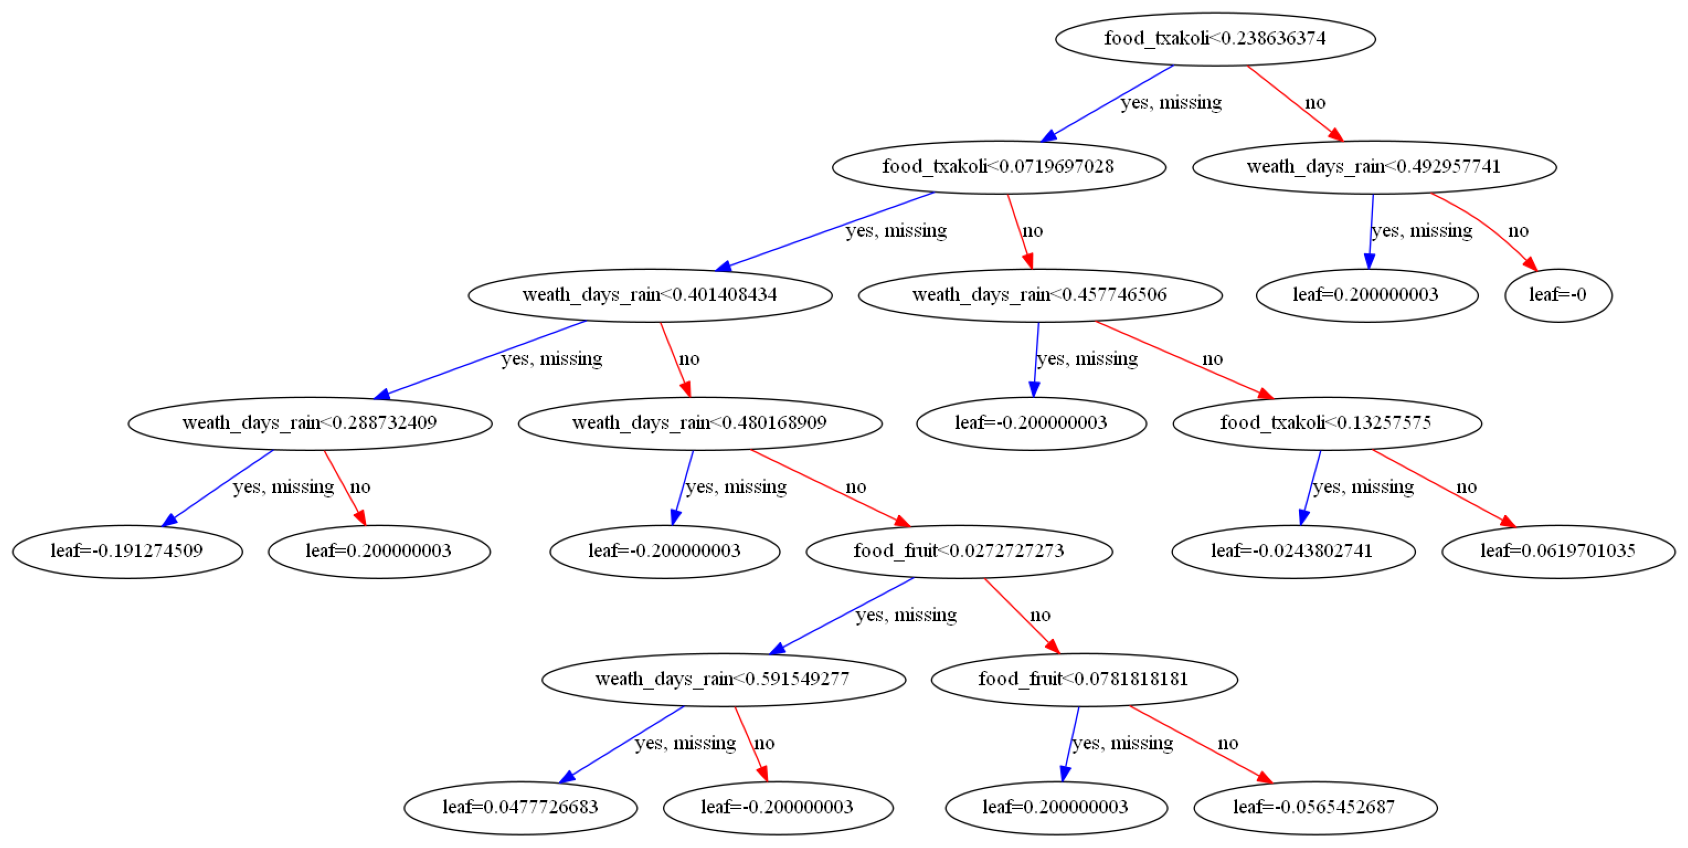

In [22]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(model, num_trees=-1, ax=ax)
plt.show()

### Apply the model to new data:

- For supervised learning, predict labels for unknown data using the `.predict()` method

In [23]:
# make a prediction

prediction_2020 = model.predict(X_test)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


## Add Each Cluster Predictions to the original DataFrame and Save it as a `.csv file`

In [24]:
# Create a new Column with the 2020 prediction
queen_predict["nests_2020"] = prediction_2020

In [25]:
# Create a new DataFrame with the Municipalities to insert manualy

HEX_aux = pd.DataFrame({"CODIGO MUNICIPIO":[48020],\
             "NOMBRE MUNICIPIO":["Bilbao"],\
             "NIDOS 2020":[0]})

In [26]:
HEX = queen_predict.loc[:,["municip_code","municip_name_x","nests_2020"]].round() # create a new Dataframe for Kopuru submission
HEX.columns = ["CODIGO MUNICIPIO","NOMBRE MUNICIPIO","NIDOS 2020"] # change column names to Spanish (Decidata template)
HEX = HEX.append(HEX_aux, ignore_index=True) # Add rows of municipalities to add manually

In [27]:
# Final check

check_data(HEX)

Submission form Shape is (112, 3)
Number of Municipalities is 112
The Total 2020 Nests' Prediction is 3126


'All Municipality Names and Codes to be submitted match the Template'

In [ ]:
# reset max_rows to default values (used in function to see which rows did not match template)

pd.reset_option("max_rows")

In [482]:
# Save the new dataFrame as a .csv in the current working directory on Windows

HEX.to_csv("WaspBusters_20210519_XGyears_scaledX.csv", index=False)